Abas identificadas: ['Tarefa', 'Gramática', 'LL(1)', 'SLR', 'LR(1)']
screenshots/Tarefa-384x726.png


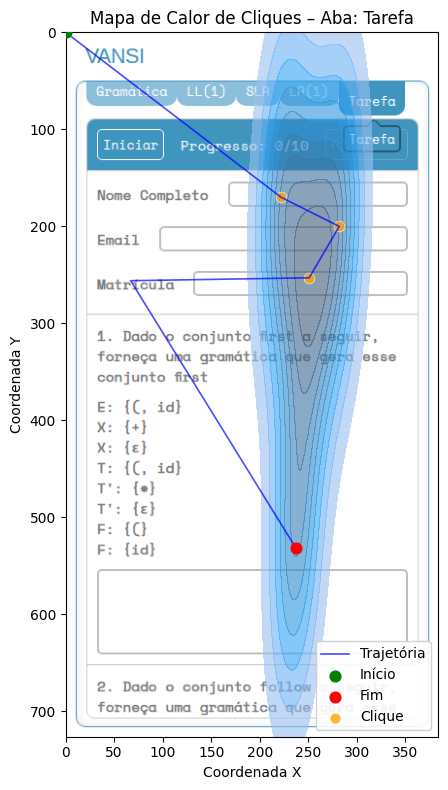

screenshots/LL(1)-384x726.png


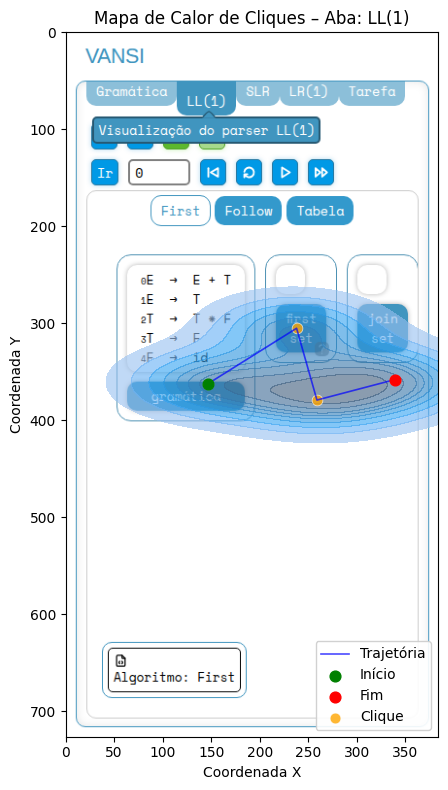

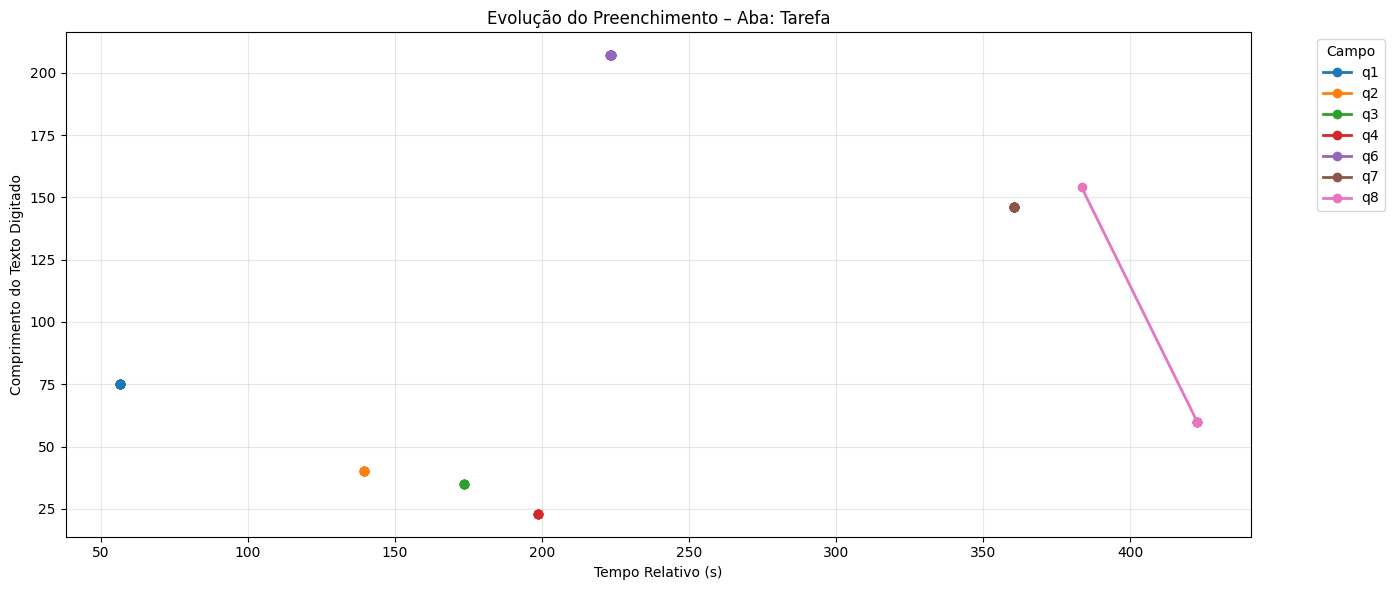

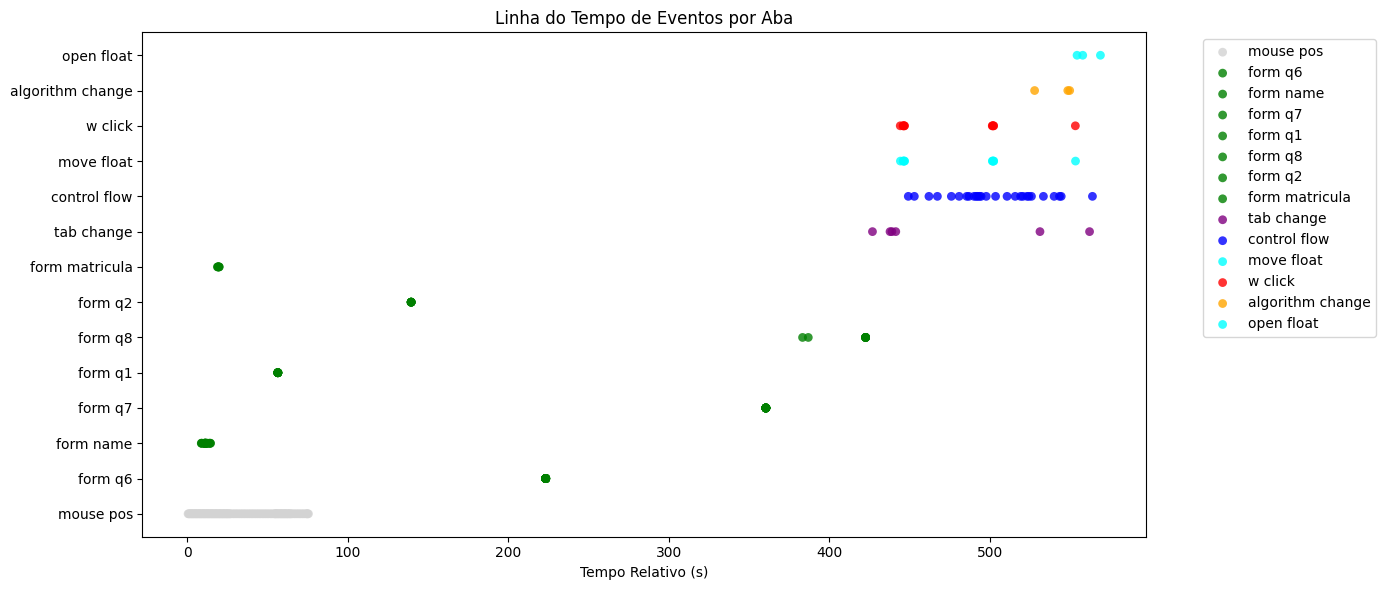


 RESUMO DE ATIVIDADE POR ABA:

Tarefa:
  Duração: 571.2s
  Cliques: 4

Gramática:
  Duração: 12.1s
  Cliques: 0

LL(1):
  Duração: 90.1s
  Cliques: 9

SLR:
  Duração: 26.6s
  Cliques: 1

LR(1):
  Duração: 6.8s
  Cliques: 0


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import os

def get_windows(df: pd.DataFrame):
    data = []
    window_id = None
    for line_num, line in enumerate(df.values):
        x, y, width, height = np.nan, np.nan, np.nan, np.nan
        try:
            timestamp, event_type, desc, _, active_tab = line
            if isinstance(desc, (int, float, np.number)):
                if np.isnan(desc):
                    desc = ""
            elif desc is None:
                desc = ""
            
            desc=desc.strip()
            
            if event_type == 'open float':
                id_part, nums = desc.split(';', 1)
                window_id = id_part.strip()
                x, y, width, height = [float(i) for i in np.concatenate(list(map(lambda j: j.split(), nums.split(";"))))]

            elif event_type == 'move float' or event_type=="resize float":
                if desc.startswith('end'):
                    _, nums = desc.split(';', 1)
                    x, y, width, height = [float(i) for i in np.concatenate(list(map(lambda j: j.split(), nums.split(";"))))]
                else:
                    _, window_id = desc.split(';')
        
            elif event_type == 'close float':
                window_id = desc.strip()

            data.append({
                'timestamp': timestamp,
                'type': event_type,
                'active_tab': active_tab,
                'window_id': window_id,
                'x': x,
                'y': y,
                'width': width,
                'height': height
            })

        except Exception as e:
            print(f"Error parsing line {line_num}: {line} -> {e}")
            continue
    df = pd.DataFrame(data)
    return df[(~df['x'].isna())]

file_path = "log.txt"
df = pd.read_csv(file_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])

def parse_mouse_desc(desc):
    if ';' not in desc:
        return pd.Series([np.nan, np.nan, np.nan, np.nan])
    mouse_str, win_str = desc.split(';')
    try:
        mx, my = map(int, mouse_str.split())
        wx, wy = map(int, win_str.split())
        return pd.Series([mx, my, wx, wy])
    except:
        return pd.Series([np.nan, np.nan, np.nan, np.nan])

mouse_events = df[df['type'].isin(['mouse pos', 'w click'])].copy()
parsed = mouse_events['desc'].apply(parse_mouse_desc)
mouse_events[['mouse_x', 'mouse_y', 'win_width', 'win_height']] = parsed
mouse_events.dropna(subset=['mouse_x', 'mouse_y', 'win_width', 'win_height'], inplace=True)
mouse_events['mouse_x'] = mouse_events['mouse_x'].astype(int)
mouse_events['mouse_y'] = mouse_events['mouse_y'].astype(int)

mouse_events['win_width'] = mouse_events['win_width'].ffill()
mouse_events['win_height'] = mouse_events['win_height'].ffill()
mouse_events['dx'] = mouse_events['mouse_x'].diff()
mouse_events['dy'] = mouse_events['mouse_y'].diff()
mouse_events['distance'] = np.sqrt(mouse_events['dx']**2 + mouse_events['dy']**2)

filtered_mouse_events = mouse_events[mouse_events['distance'] > 1.0 ].copy()
filtered_mouse_events = pd.concat([mouse_events.iloc[[0]], filtered_mouse_events]).drop_duplicates()
significant_mouse_indices = set(filtered_mouse_events.index)

start_time = df['timestamp'].min()
mouse_events['relative_time'] = (mouse_events['timestamp'] - start_time).dt.total_seconds()
df['relative_time'] = (df['timestamp'] - start_time).dt.total_seconds()
tab_changes = df[df['type'] == 'tab change'].copy()
tab_changes['tab_name'] = tab_changes['desc']
tab_changes = tab_changes[['timestamp', 'tab_name']].sort_values('timestamp')

df_sorted = df.sort_values('timestamp')
tabs_list = tab_changes.to_dict('records')

def get_active_tab(ts):
    active = "Início"
    for t in tabs_list:
        if ts >= t['timestamp']:
            active = t['tab_name']
        else:
            break
    return active

df['active_tab'] = df['timestamp'].apply(get_active_tab)
mouse_events['active_tab'] = mouse_events['timestamp'].apply(get_active_tab)
df_windows = get_windows(df)

form_events = df[df['type'].str.startswith('form ')].copy()
form_events['field'] = form_events['type'].apply(lambda x: x.split(' ', 1)[1] if ' ' in x else x)
form_events['input_value'] = form_events['desc'].apply(lambda x: x.split(',', 1)[1] if isinstance(x, (str)) and ',' in x and len(x.split(',',1))>1 else x)
form_events = form_events.dropna(subset=['input_value'])
form_events['active_tab'] = form_events['timestamp'].apply(get_active_tab)

clicks = mouse_events[mouse_events['type'] == 'w click']
extra_pos = clicks.copy()
extra_pos["type"] = extra_pos['type'].map(lambda _: "mouse pos")

mouse_events = pd.concat([mouse_events, extra_pos]).sort_values("timestamp")
mouse_moves = mouse_events[mouse_events['type'] == 'mouse pos'].drop_duplicates()

tabs_used = [t for t in df['active_tab'].unique()]
print(f"Abas identificadas: {tabs_used}")

# ===================================================================
# Heatmap de Cliques por Aba
# ===================================================================
for tab in tabs_used:
    tab_clicks = clicks[clicks['active_tab'] == tab]
    if tab_clicks.empty:
        continue

    tab_moves = mouse_moves[mouse_moves['active_tab'] == tab]
    if len(tab_moves) < 2:
        continue

    sampled = tab_moves.iloc[::1]
    mode_width = int(tab_clicks['win_width'].mode()[0])
    mode_height = int(tab_clicks['win_height'].mode()[0])

    img_path = f'screenshots/{tab}-{mode_width}x{mode_height}.png'
    if not os.path.exists(img_path):
        os.system(f"node screenshot.cjs \"{tab}\" {mode_width} {mode_height}") 
    print(img_path)
    img = mpimg.imread(img_path)

    img_height, img_width = img.shape[:2]

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.imshow(img, extent=[0, img_width, img_height, 0])  
    
    ax.set_xlim(0, img_width)
    ax.set_ylim(img_height, 0)  
    ax.set_clip_on(True)

    ax.plot(sampled['mouse_x'], sampled['mouse_y'], color='blue', linewidth=1.2, alpha=0.7, label='Trajetória')
    ax.scatter(sampled.iloc[0]['mouse_x'], sampled.iloc[0]['mouse_y'], color='green', s=60, label='Início', zorder=5)
    ax.scatter(sampled.iloc[-1]['mouse_x'], sampled.iloc[-1]['mouse_y'], color='red', s=60, label='Fim', zorder=5)

    sns.kdeplot(ax=ax,data=tab_clicks, x='mouse_x', y='mouse_y', fill=True, alpha=0.6, thresh=0.1, warn_singular=False)
    ax.scatter(tab_clicks['mouse_x'], tab_clicks['mouse_y'], color='orange', s=60, alpha=0.8, edgecolor='white', linewidth=0.5, label='Clique')

    sample = df_windows[df_windows['active_tab']==tab]
    window_ids = sample['window_id'].dropna().unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(window_ids)))
    color_map = {wid: colors[i] for i, wid in enumerate(window_ids)}
    lng = len(sample)-1
    i = -1
    for _, row in sample.iterrows():    
        x, y = row['x'], row['y']
        w = row['width'] 
        h = row['height']
        window_id = row['window_id']
        color = color_map.get(window_id, (0.5, 0.5, 0.5))

        i += 1
        p = i / lng
        alpha = (p + 0.2) / 1.2

        color_array = np.array(color)
        
        # FIX: Create edgecolor properly (don't multiply RGBA by scalar)
        edgecolor = color_array.copy()
        edgecolor[:3] = edgecolor[:3] * p  # Multiply RGB, keep alpha
        
        # Adjust linewidth based on recency
        lw = 2.5 * (1 - 0.5 * p)  # Thicker for newer windows
        
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=lw,
            edgecolor=edgecolor,
            facecolor='none',
            alpha=alpha
        )
        ax.text(x + 5, y - 10, window_id, fontsize=9, color=np.array(color)*p, weight='bold', alpha=alpha)


    plt.title(f'Mapa de Calor de Cliques – Aba: {tab}')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.xlim(0, img_width)
    plt.ylim(img_height, 0)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        ax.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=10, framealpha=0.9)

    # ax.axis("off")
    fig.tight_layout()
    plt.show()

# ===================================================================
# Evolução do Preenchimento do Formulário por Aba
# ===================================================================
if not form_events.empty:
    q_fields = [f for f in form_events['field'].unique() if 'q' in f.lower()]
    for tab in tabs_used:
        data_tab = form_events[form_events['active_tab'] == tab]
        if data_tab.empty or not any(f in data_tab['field'].values for f in q_fields):
            continue
        plt.figure(figsize=(14, 6))
        for field in q_fields:
            data_field = data_tab[data_tab['field'] == field]
            if data_field.empty:
                continue
            times = data_field['relative_time']
            lengths = [len(v) for v in data_field['input_value']]
            plt.plot(times, lengths, marker='o', label=field, linewidth=2)

        plt.title(f'Evolução do Preenchimento – Aba: {tab}')
        plt.xlabel('Tempo Relativo (s)')
        plt.ylabel('Comprimento do Texto Digitado')
        plt.legend(title="Campo", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# ===================================================================
# Linha do Tempo de Eventos por Aba
# ===================================================================
plt.figure(figsize=(14, 6))
for tab in tabs_used:
    data = df[df['active_tab'] == tab]
    types = data['type'].value_counts().head(8).index
    for etype in types:
        subset = data[data['type'] == etype]
        color_map = {
            'w click': 'red',
            'mouse pos': 'lightgray',
            'tab change': 'purple',
            'algorithm change': 'orange',
            'control flow': 'blue',
            'form ': 'green',
            'grab float': 'cyan',
            'open float': 'cyan',
            'move float': 'cyan'
        }
        color = 'gray'
        for k, c in color_map.items():
            if k in etype:
                color = c
                break
        plt.scatter(subset['relative_time'], [etype] * len(subset), color=color, s=40, alpha=0.8, edgecolor='none', label=etype if etype not in plt.gca().get_legend_handles_labels()[1] else "")

plt.yticks(rotation=0)
plt.xlabel('Tempo Relativo (s)')
plt.title('Linha do Tempo de Eventos por Aba')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ===================================================================
# Atividade por Aba
# ===================================================================
print("\n RESUMO DE ATIVIDADE POR ABA:")
for tab in tabs_used:
    tab_data = df[df['active_tab'] == tab]

    duration = tab_data['relative_time'].max() - tab_data['relative_time'].min()
    clicks_in_tab = tab_data[tab_data['type'] == 'w click'].shape[0]
    print(f"\n{tab}:")
    print(f"  Duração: {duration:.1f}s")
    print(f"  Cliques: {clicks_in_tab}")
    

/tmp/ipykernel_34744/4258835187.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_tab_counts = df.groupby([bins, 'active_tab']).size().unstack(fill_value=0)


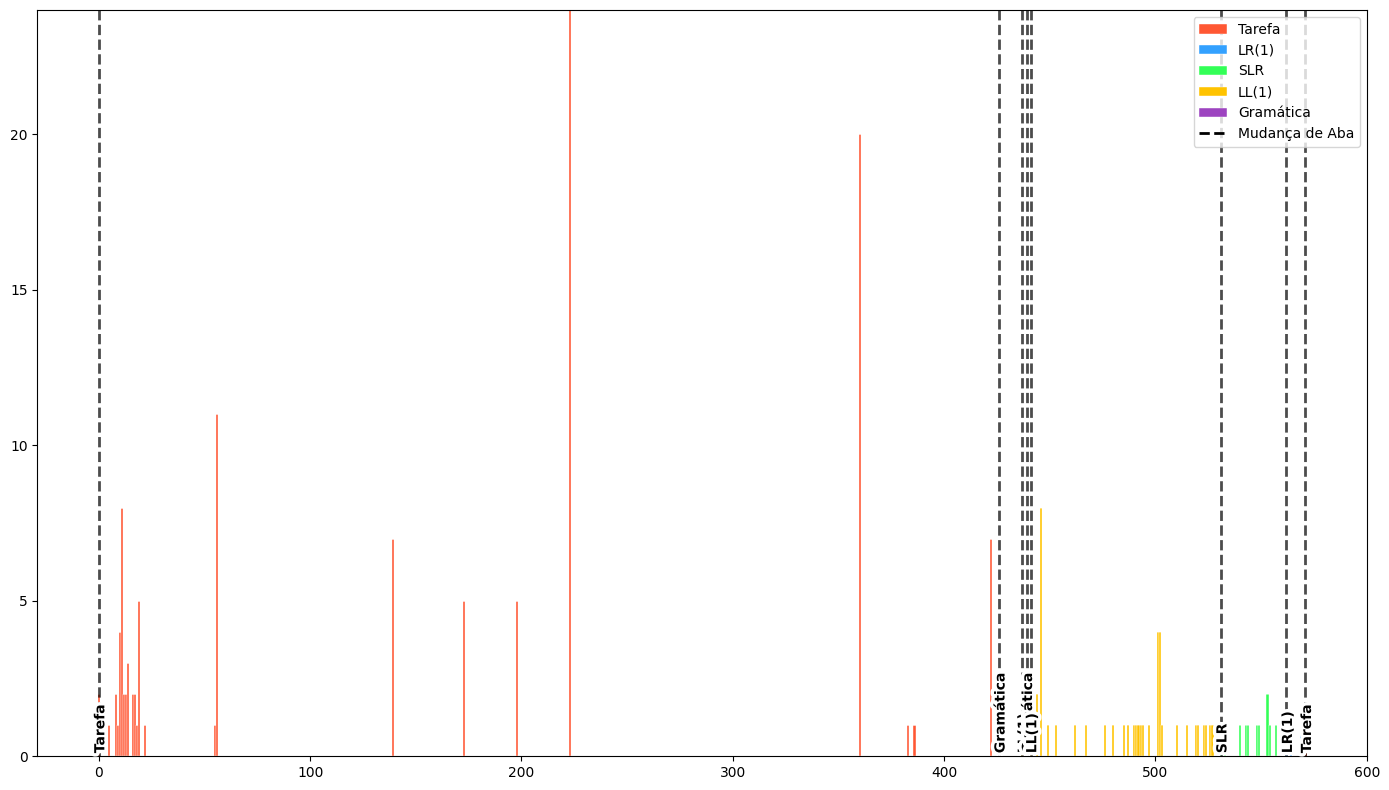

In [2]:
from matplotlib import patheffects
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

start_time = df['timestamp'].min()
df['relative_seconds'] = (df['timestamp'] - start_time).dt.total_seconds()

def classify_event(row):
    t = row['type']
    idx = row.name 
    if t == 'mouse pos':
        if idx in significant_mouse_indices:
            return 'mouse move'
        else:
            return 'mouse idle'
    else:
        return t

df['event_category'] = df.apply(classify_event, axis=1)

events_for_plot = df[df['event_category'] != 'mouse idle'].copy()

up = int(events_for_plot['relative_seconds'].max()) + 2
low = int(events_for_plot['relative_seconds'].min())

bin_edges = [x / 10.0 for x in range(low*10, up*10, 10)]
bins = pd.cut(events_for_plot['relative_seconds'], bins=bin_edges, right=False, labels=bin_edges[:-1])
bin_tab_counts = df.groupby([bins, 'active_tab']).size().unstack(fill_value=0)

fig, ax1 = plt.subplots(figsize=(14, 8))

unique_bins = bin_tab_counts.index.astype(float)
tab_indices = bin_tab_counts.idxmax(axis=1) 
tab_colors = {
    'Tarefa': '#FF5733',      
    'LR(1)': '#33A1FF',     
    'SLR': '#33FF57',       
    'LL(1)': '#FFC300',     
    'Gramática': '#9D44C0',   
} 

all_tabs = bin_tab_counts.columns
for tab in tab_colors.keys():
    if tab not in all_tabs:
        bin_tab_counts[tab] = 0

bin_tab_counts = bin_tab_counts[list(tab_colors.keys())]

bottom = None
bars = []
for tab in bin_tab_counts.columns:
    color = tab_colors[tab]
    ax1.bar(
        bin_tab_counts.index.astype(float),
        bin_tab_counts[tab],
        bottom=bottom,
        color=color,
        label=tab,
        width=(up-3)/(len(bin_edges)),
        edgecolor='white',
        linewidth=0.3
    )
    if bottom is None:
        bottom = bin_tab_counts[tab]
    else:
        bottom += bin_tab_counts[tab]
    bars.append(Patch(color=color, label=tab))

for _, row in tab_changes.iterrows():
    t_sec = int(up*((row['timestamp'] - start_time).total_seconds()/up))
    
    ax1.axvline(
        x=t_sec,
        color='black',
        linestyle='--',
        linewidth=2,
        alpha=0.7
    )
    txt = ax1.text(
        t_sec+0.7, 0.1, row['tab_name'],
        rotation=90, verticalalignment='bottom', horizontalalignment='center',
        fontsize=10, color='black', weight='bold'
    )

    txt.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])

ax1.legend(handles=bars, title='Aba Ativa', bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.legend(handles=bars, title='Aba Ativa', bbox_to_anchor=(1.05, 1), loc='upper left')
handles, labels = ax1.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)


unique_handles.append(Line2D([0], [0], color='black', linestyle='--', linewidth=2))
unique_labels.append('Mudança de Aba')
plt.legend(unique_handles, unique_labels, loc='upper right', fontsize=10)
legend_elements = [Patch(facecolor=tab_colors[tab], label=tab) for tab in tab_colors]

plt.tight_layout()
plt.show()

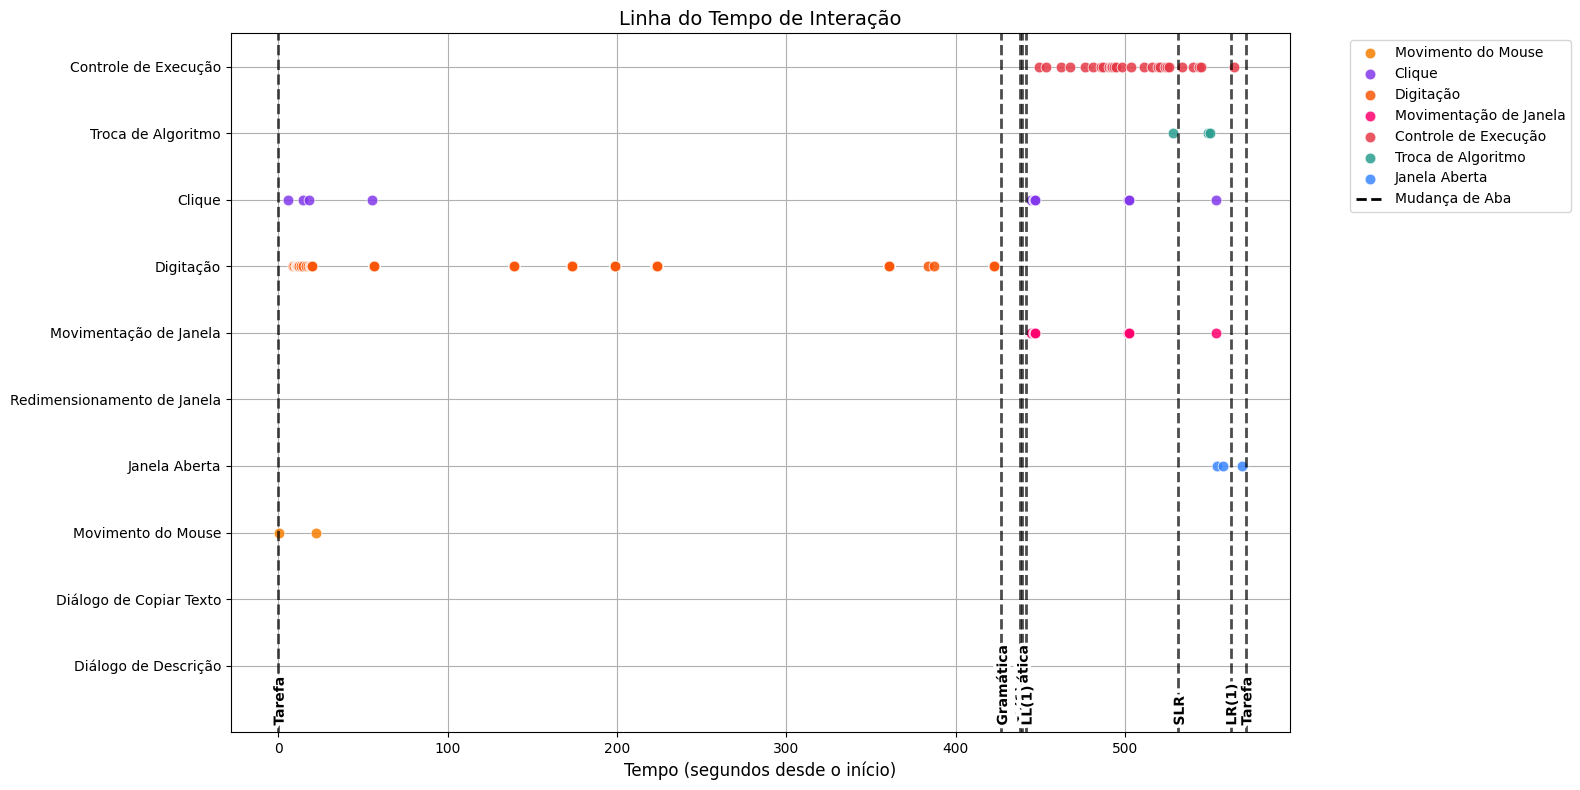

In [3]:
mouse_events["dx"] = mouse_events["mouse_x"].diff()
mouse_events["dy"] = mouse_events["mouse_y"].diff()
mouse_events["distance"] = np.sqrt(mouse_events["dx"] ** 2 + mouse_events["dy"] ** 2)

filtered_mouse_events = mouse_events[mouse_events["distance"] > 1.0].copy()
filtered_mouse_events = pd.concat(
    [mouse_events.iloc[[0]], filtered_mouse_events]
).drop_duplicates()
significant_mouse_indices = set(filtered_mouse_events.index)


def classify_event(row):
    t = row["type"]
    idx = row.name
    if t == "mouse pos":
        if idx in significant_mouse_indices:
            return "Movimento do Mouse"
        else:
            return "Ignorado (mouse parado)"
    elif t == "w click":
        return "Clique"
    elif "form " in t:
        return "Digitação"
    elif t == "tab change":
        return "Mudança de Aba"
    elif t == "open float":
        return "Janela Aberta"
    elif t == "open popup":
        if "text" in row["desc"]:
            return "Diálogo de Copiar Texto"
        else:
            return "Diálogo de Descrição"
    elif t == "move float":
        return "Movimentação de Janela"
    elif t == "resize float":
        return "Redimensionamento de Janela"
    elif t == "algorithm change":
        return "Troca de Algoritmo"
    elif t == "control flow":
        return "Controle de Execução"
    else:
        return "Outro"


df["event_category"] = df.apply(classify_event, axis=1)

events_for_plot = df[df["event_category"] != "Ignorado (mouse parado)"].copy()

events_for_scatter = events_for_plot[events_for_plot["type"] != "tab change"].copy()

categories = [
    "Controle de Execução",
    "Troca de Algoritmo",
    "Clique",
    "Digitação",
    "Movimentação de Janela",
    "Redimensionamento de Janela",
    "Janela Aberta",
    "Movimento do Mouse",
    "Diálogo de Copiar Texto",
    "Diálogo de Descrição",
]

y_positions = {cat: idx for idx, cat in enumerate(categories)}
events_for_scatter["y_pos"] = events_for_scatter["event_category"].map(y_positions)

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_axisbelow(True)
ax.grid()
colors = [
    "#e63946",
    "#2a9d8f",
    "#8338ec",
    "#fb5607",
    "#ff006e",
    "#8d99ae",
    "#3a86ff",
    "#f77f00",
    "#49CE37",
    "#322485",
]
color_map = {cat: color for cat, color in zip(categories, colors)}

for category in events_for_scatter["event_category"].unique():
    if category not in color_map:
        continue
    data_cat = events_for_scatter[events_for_scatter["event_category"] == category]
    ax.scatter(
        data_cat["relative_seconds"],
        data_cat["y_pos"],
        color=color_map[category],
        s=60,
        alpha=0.85,
        edgecolor="white",
        linewidth=0.6,
        label=category,
    )

for _, row in tab_changes.iterrows():
    t_sec = (row["timestamp"] - start_time).total_seconds()
    ax.axvline(x=t_sec, color="black", linestyle="--", linewidth=2, alpha=0.7)
    t_sec = t_sec + 0.9
    txt = ax.text(
        t_sec,
        len(categories) - 0.1,
        row["tab_name"],
        rotation=90,
        verticalalignment="bottom",
        horizontalalignment="center",
        fontsize=10,
        color="black",
        weight="bold",
    )

    txt.set_path_effects([patheffects.withStroke(linewidth=5, foreground="w")])

ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)
ax.set_xlabel("Tempo (segundos desde o início)", fontsize=12)
ax.set_title("Linha do Tempo de Interação", fontsize=14)
ax.invert_yaxis()
ax.set_ylim(len(categories), -0.5)

handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

from matplotlib.lines import Line2D

unique_handles.append(Line2D([0], [0], color="black", linestyle="--", linewidth=2))
unique_labels.append("Mudança de Aba")

ax.legend(
    unique_handles,
    unique_labels,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=10,
)
plt.tight_layout()

In [ ]:
import pandas as pd
import os
from pathlib import Path
from typing import Dict, List, Optional

def extract_last_form_values(file_path) -> Dict[str, Dict]:
    try:
        df = pd.read_csv(file_path)
        
        form_events = df[df['type'].str.startswith('form ')].copy()
        
        if form_events.empty:
            return {}
        
        form_events['field_name'] = form_events['type'].str.replace('form ', '', regex=False)
        
        form_events = form_events.sort_values('timestamp')
        
        last_values = {}
        
        for field in form_events['field_name'].unique():
            field_entries = form_events[form_events['field_name'] == field]
            last_entry = field_entries.iloc[-1]
            last_values[field] = last_entry['desc']
        
        return last_values
        
    except Exception as e:
        print(f"  Error processing {file_path}: {e}")
        return {}

def process_logs_directory(directory_path: str = "./logs") -> Dict[str, Dict]:
    logs_dir = Path(directory_path)
    
    if not logs_dir.exists():
        print(f"Directory {directory_path} does not exist.")
        return {}
    
    if not logs_dir.is_dir():
        print(f"{directory_path} is not a directory.")
        return {}
    
    log_files = []
    for item in logs_dir.iterdir():
        if item.is_file():
            if '.' not in item.name or item.name.startswith('.'):
                log_files.append(item)
    all_results = {}
    
    for file_path in log_files:
        file_results = extract_last_form_values(str(file_path))
        
        if file_results:
            all_results[file_path.name] = file_results
    
    return all_results

def create_summary_dataframe(results: Dict[str, Dict]) -> pd.DataFrame:
    for filename, form_values in results.items():
        print(f"{form_values.get('name')},{form_values.get('matricula')},{form_values.get("email")}")


In [ ]:
create_summary_dataframe(process_logs_directory())